# Recurrent switching linear dynamical systems (rSLDS)

In [1]:
# #Install ssm pacakage
# %cd ssm
# %pip install numpy cython
# %pip install -e .

In [2]:
# %cd /Users/jryu/proj
# %git clone git@github.com:slinderman/ssm.git
# %cd /Users/jryu/proj/ssm
# %pip install numpy cython
# %pip install -e .

In [3]:
# %cd /Users/jryu/proj/det_rnn
# %pip install -r requirements.txt

In [4]:
import os, pickle, copy, sys

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

In [5]:
# import detrnn packages
sys.path.append('../')
from det_rnn import *
import det_rnn.train as utils_train
import det_rnn.analysis as utils_analysis
from det_rnn.train.model import Model

from models.base.analysis import behavior_summary, estimation_decision

from utils.plotfnc import *

In [6]:
# Global parameters
N = 20         # number of neurons 
# T = 500 # determined by the detrnn module
K = 2                # discrete states: evidence accumulation and "memory"
D_obs    = 2*N   # observation: gaussian
D_latent = N         # 

In [7]:
par_train = copy.deepcopy(par)
par_train['batch_size'] = 5 # smaller batch size
par_train['n_ori'] = N
par_train['n_tuned_input'] = N
par_train['n_tuned_output'] = N
par_train['n_hidden'] = N
par_train['design'] = {'iti' : (0, 0.2), 'stim': (0.2,1.2), 'delay': ((1.2, 1.5),(3.2,3.3)),
                       'decision': (1.5, 3.2),  'estim'   : (3.3, 3.5)}
par_train = update_parameters(par_train)
stim_train = Stimulus(par_train)

# generate training data
train_data = stim_train.generate_trial()

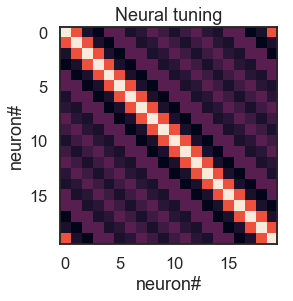

In [8]:
A = stim_train.tuning_input[:,0,:]
u, s, vh = np.linalg.svd(A, full_matrices=True)
snew = np.zeros((N,))
snew[0:11] = 1  
smat = np.diag(snew)
A = np.dot(u, np.dot(smat, vh))

plt.imshow(A)
plt.title('Neural tuning')
plt.xlabel('neuron#')
plt.ylabel('neuron#')
plt.show()

orientation = 117.0, reference = 153.0


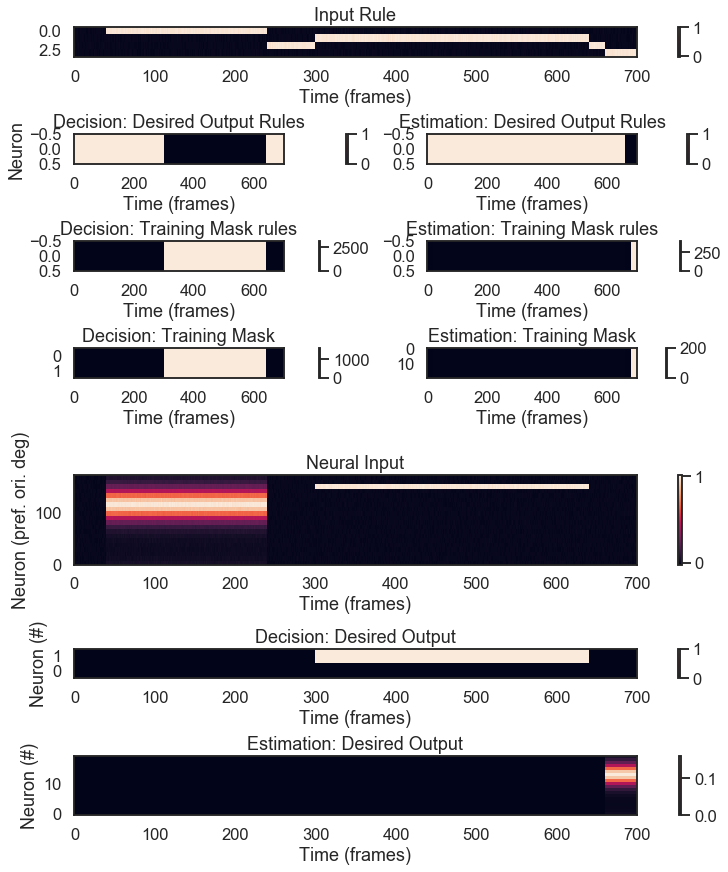

In [9]:
random_trial_num = 0
# random_trial_num = 2
target_ori = np.arange(0,180,180/par_train['n_ori'])[train_data['stimulus_ori'][random_trial_num]]
ref_ori = np.arange(0,180,180/par_train['n_tuned_input'])[train_data['ref_neuron'][random_trial_num]]
print('orientation = ' + str(target_ori) + ', reference = ' + str(ref_ori))
plot_trial(train_data, stim_train, TEST_TRIAL=random_trial_num)

## Robustness to distractors

In [10]:
nrule = stim_train.n_rule_input
data  = train_data['neural_input']
Usize = data.shape[2]
T     = data.shape[0]
inpt  = [data[:,i,:] for i in range(data.shape[1])]

In [11]:
# continuous state updates
def build_distractor_resistant_SLDS(N, K, D_obs, D_latent, data, stim_train, gain_d = 10,alpha = 0.1):
    Usize = data.shape[2]
    T     = data.shape[0]
    inpt  = [data[:,i,:] for i in range(data.shape[1])]
    
    nrule = stim_train.n_rule_input    
    A = stim_train.tuning_input[:,0,:]
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    snew = np.zeros((N,))
    snew[0:11] = 1  
    smat = np.diag(snew)
    A = np.dot(u, np.dot(smat, vh))
    
    if False:
        plt.imshow(A)
        plt.title('Neural tuning')
        plt.xlabel('neuron#')
        plt.ylabel('neuron#')
        plt.show()
    
    Anorm = np.eye(D_latent) * (1 - alpha) + alpha* A

    As = [Anorm, Anorm]
    bs = np.zeros((K,D_latent)) 
    Vs = [np.column_stack((np.zeros((N,nrule)), alpha*A)), np.zeros((N,Usize))]

    # discrete state updates
    R = np.zeros((D_latent,))
    Rs = [R, R] # continuous state dependent updates
    # r = 
    rs = np.zeros((K,))

    w1 = np.zeros(Usize) # support for state 0 = accumulation state
    w1[0] = 1
    w1[1:4] = -1
    w2 = np.zeros(Usize) # support for state 1 = memory state (distractor resistance)
    w2[0] = -1
    w2[1:4] = 1
    Ws = np.row_stack((gain_d*w1, gain_d*w2))

    # transition matrix
    tgain = 0.98
    Trans = np.eye(K) * tgain + (np.ones((K,K)) - np.eye(K))* (1-tgain)/(K-1)

    # construct true rslds num_states, obs_dim, input_dim
    true_rslds = ssm.SLDS(D_obs, K, D_latent, M = Usize, 
                          transitions="recurrent",
                          dynamics="diagonal_gaussian",
                          emissions="gaussian_orthog",
                          single_subspace=True)

    true_rslds.dynamics.mu_init = np.zeros((K,D_latent))
    true_rslds.dynamics.sigmasq_init = 1e-4 * np.ones((K, D_latent))
    true_rslds.dynamics.As = np.array(As)
    true_rslds.dynamics.bs = np.array(bs)
    true_rslds.dynamics.Vs = np.array(Vs)
    true_rslds.dynamics.sigmasq = 1e-4 * np.ones((K, D_latent))

    true_rslds.transitions.Ws = np.array(Ws)
    true_rslds.transitions.Rs = np.array(Rs)
    true_rslds.transitions.r  = np.array(rs)
    # true_rslds.transitions.transition_matrix = Trans # why doesnt this work?

    true_rslds.emissions.inv_etas = np.log(1e-2) * np.ones((1, D_obs))
    
    return true_rslds

In [12]:
def sample_and_plot_discretegain(data, stim_train, gain_discrete):
    T     = data.shape[0]
    B     = data.shape[1]
    inpt  = [data[:,i,:] for i in range(data.shape[1])]
    # sample network behavior
    true_rslds =  build_distractor_resistant_SLDS(N, K, D_obs, D_latent, data, stim_train, gain_d = gain_discrete)
    
    zs, xs, ys = [], [], []
    for sess in range(B):
        z, x, y = true_rslds.sample(T=T, input = inpt[sess])
        zs.append(z)
        xs.append(x)
        ys.append(y)

    plt.figure(figsize=(15, 10)) 
    plt.subplot(3,1,1)
    plt.imshow(data[:,-1,nrule:].T,origin='upper',interpolation='none',aspect='auto')
    plt.title("Inputs")
    plt.xlabel("Time (frames)")
    plt.ylabel("Neuron (pref. ori. deg)")
    plt.colorbar()

    plt.subplot(3,1,2)
    plt.imshow(x.T,origin='upper',interpolation='none',aspect='auto')
    plt.colorbar()
    plt.scatter(np.arange(x.shape[0]), np.argmax(x,axis=1),2,label='max', alpha=0.2)
    plt.xlim((0,x.shape[0]))
    plt.title("Recurrent neurons (continuous states)")
    plt.xlabel("Time (frames)")
    plt.ylabel("Neuron (pref. ori. deg)")

    plt.subplot(3,1,3)
    plt.imshow(z[None,:],origin='upper',interpolation='none',aspect='auto')
    plt.title("Brain state (discrete states)")
    plt.xlabel("Time (frames)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    return true_rslds, zs,xs,ys

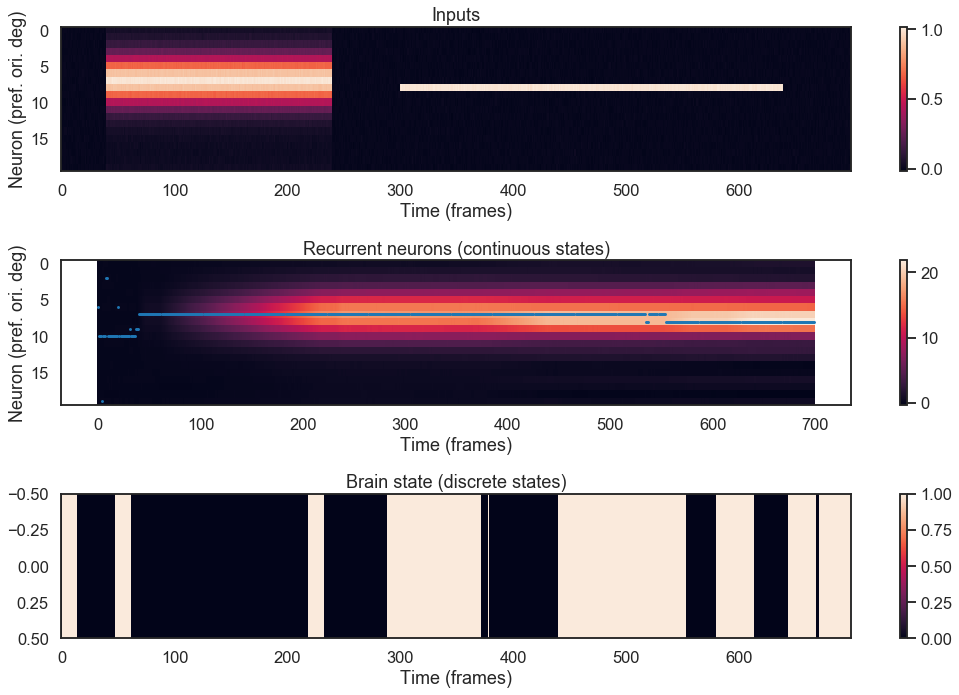

In [13]:
true_rslds, zs,xs,ys = sample_and_plot_discretegain(data,stim_train,gain_discrete = 0)

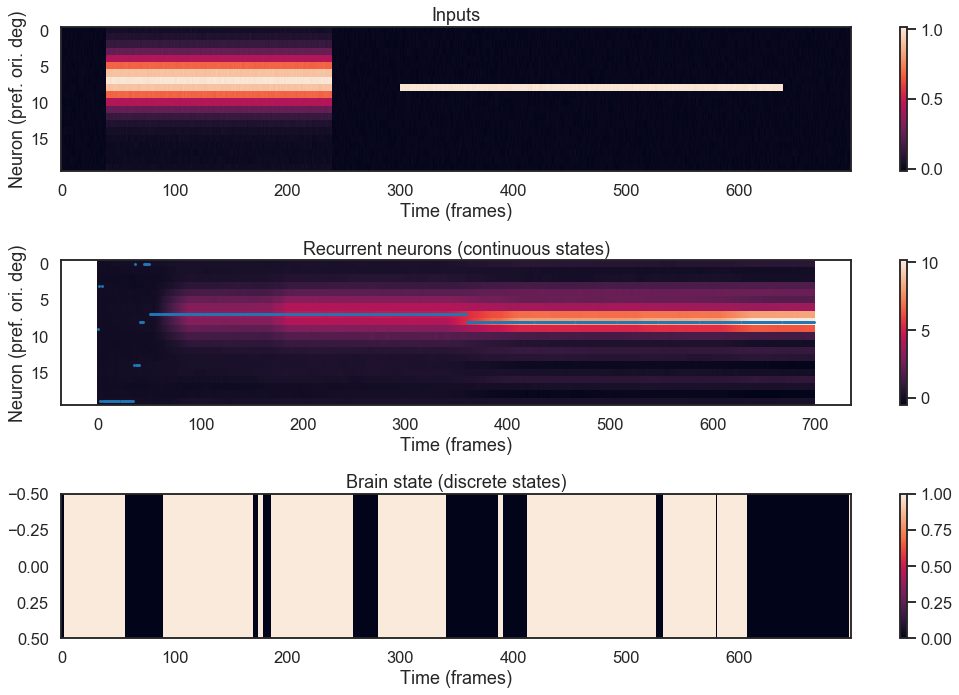

In [14]:
_,_,_,_ = sample_and_plot_discretegain(data,stim_train,gain_discrete = 0)

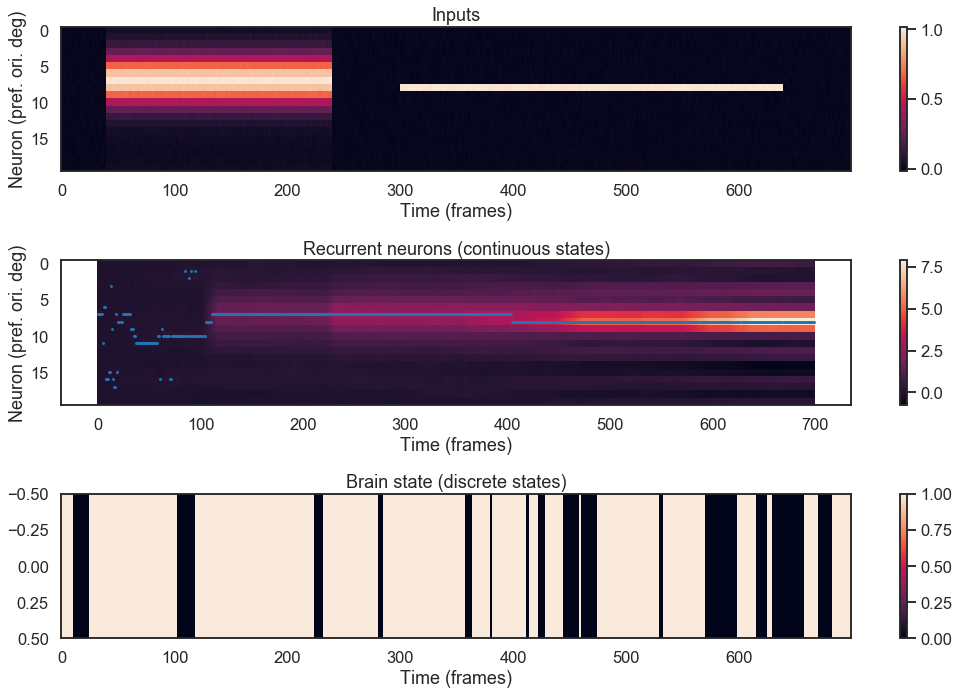

In [15]:
_,_,_,_ = sample_and_plot_discretegain(data,stim_train,gain_discrete = 0)

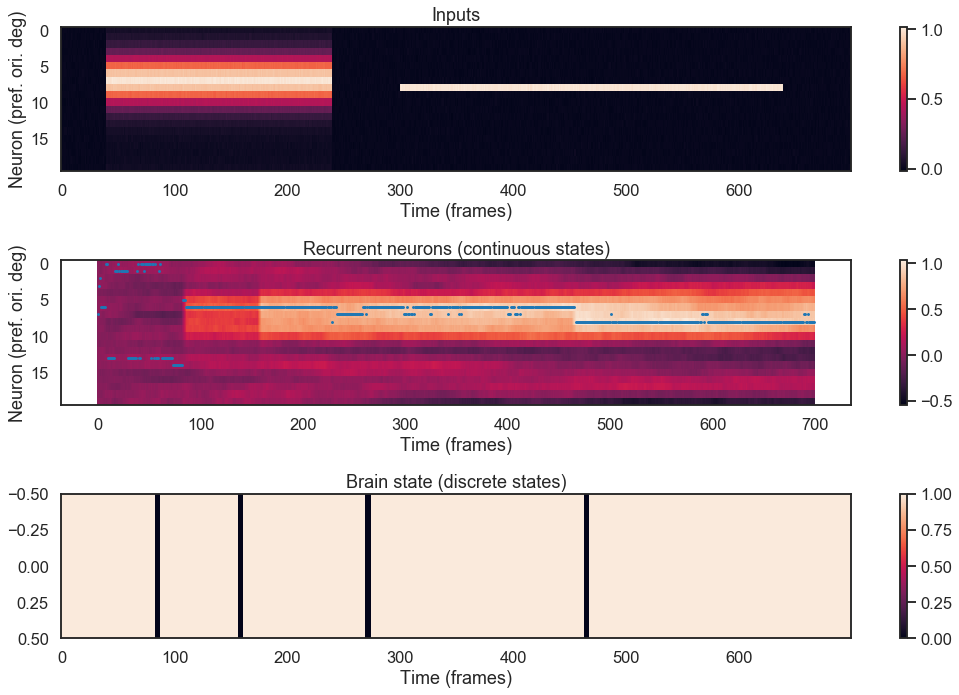

In [16]:
_,_,_,_ = sample_and_plot_discretegain(data,stim_train,gain_discrete = 0)

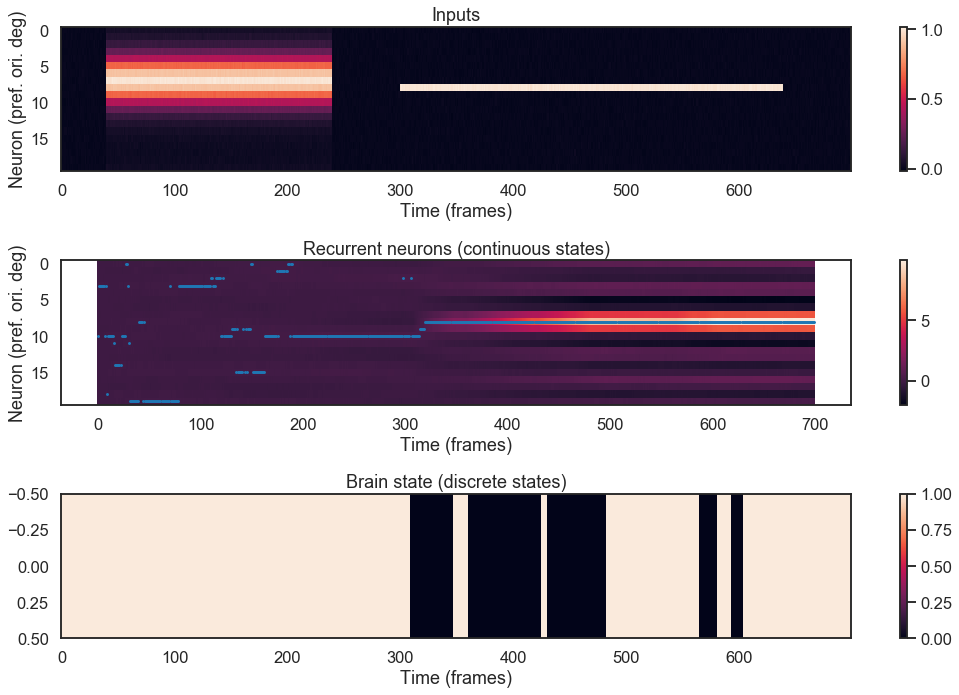

In [17]:
_,_,_,_ = sample_and_plot_discretegain(data,stim_train,gain_discrete = 0.1)

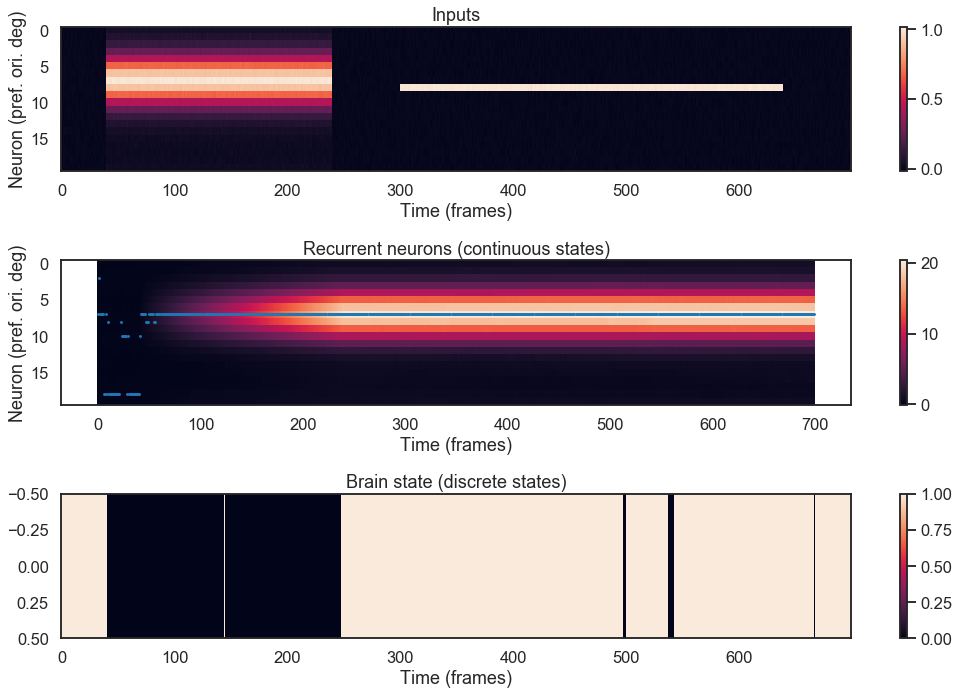

In [18]:
true_rslds,z,x,y = sample_and_plot_discretegain(data,stim_train,gain_discrete = 1)

### estimating the distractor resistant rSLDS

In [19]:
# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent, M = Usize, 
                 transitions="recurrent",
                 dynamics="diagonal_gaussian",
                 emissions="gaussian_orthog",
                 single_subspace=True)
rslds.initialize(y)
q_elbos_lem, q_lem = rslds.fit(y, 
                               inputs=inpt,
                               method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=25, alpha=0.0)

#xhat_lem = q_lem.mean_continuous_states[0]
#rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, y)))
#zhat_lem = rslds.most_likely_states(xhat_lem, y)

# store rslds
rslds_lem = copy.deepcopy(rslds)

Text(0, 0.5, 'ELBO')

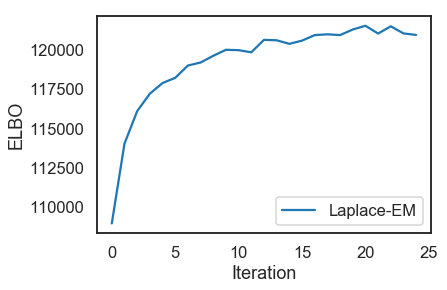

In [20]:
# Plot loglikelihood of data
plt.figure()
plt.plot(q_elbos_lem[1:], label="Laplace-EM")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("ELBO")

In [27]:
rslds_lem.transitions.Ws

array([[-0.11871234,  0.43993215,  0.7683329 ,  0.62075768, -0.16079863,
        -0.30817209, -0.21003143,  0.86668122,  0.33542327,  0.08426674,
        -0.20628195,  0.17299454, -0.28138332,  0.32187733,  0.3841376 ,
         0.28732183,  0.21459155, -0.51349337, -0.02715075, -0.05121898],
       [ 0.11871234, -0.43993215, -0.7683329 , -0.62075768,  0.16079863,
         0.30817209,  0.21003143, -0.86668122, -0.33542327, -0.08426674,
         0.20628195, -0.17299454,  0.28138332, -0.32187733, -0.3841376 ,
        -0.28732183, -0.21459155,  0.51349337,  0.02715075,  0.05121898]])

In [26]:
true_rslds.transitions.Ws

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

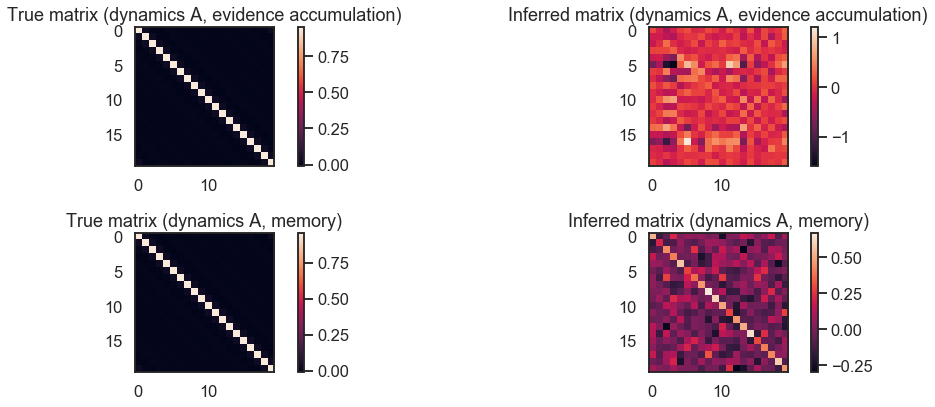

In [37]:
plt.figure(figsize=(15,6))
plt.subplot(2,2,1)
plt.imshow(true_rslds.dynamics.As[0])
plt.colorbar()
plt.title('True matrix (dynamics A, evidence accumulation)')

plt.subplot(2,2,2)
plt.imshow(rslds_lem.dynamics.As[0])
plt.colorbar()
plt.title('Inferred matrix (dynamics A, evidence accumulation)')

plt.subplot(2,2,3)
plt.imshow(true_rslds.dynamics.As[1])
plt.colorbar()
plt.title('True matrix (dynamics A, memory)')

plt.subplot(2,2,4)
plt.imshow(rslds_lem.dynamics.As[1])
plt.colorbar()
plt.title('Inferred matrix (dynamics A, memory)')

plt.tight_layout()
plt.show()

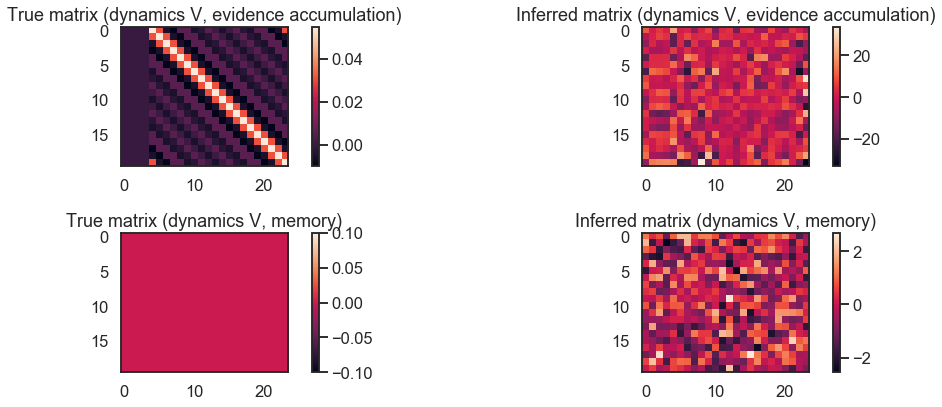

In [38]:
plt.figure(figsize=(15,6))
plt.subplot(2,2,1)
plt.imshow(true_rslds.dynamics.Vs[0])
plt.colorbar()
plt.title('True matrix (dynamics V, evidence accumulation)')

plt.subplot(2,2,2)
plt.imshow(rslds_lem.dynamics.Vs[0])
plt.colorbar()
plt.title('Inferred matrix (dynamics V, evidence accumulation)')


plt.subplot(2,2,3)
plt.imshow(true_rslds.dynamics.Vs[1])
plt.colorbar()
plt.title('True matrix (dynamics V, memory)')

plt.subplot(2,2,4)
plt.imshow(rslds_lem.dynamics.Vs[1])
plt.colorbar()
plt.title('Inferred matrix (dynamics V, memory)')

plt.tight_layout()
plt.show()

## Approximating nonlinearities with rSLDS

In [16]:
K = 6

In [42]:
np.sum(stim_train.tuning_input[:,0,:],axis=1)

array([4.93613316, 4.93613316, 4.93613316, 4.93613316, 4.93613316,
       4.93613316, 4.93613316, 4.93613316, 4.93613316, 4.93613316,
       4.93613316, 4.93613316, 4.93613316, 4.93613316, 4.93613316,
       4.93613316, 4.93613316, 4.93613316, 4.93613316, 4.93613316])

In [79]:
# continuous state updates
def build_nonexploding_SLDS(N, K, D_obs, D_latent, data, stim_train, 
                            gain_di = 2, gain_dx = 1/20, alpha=0.2, neuron_thresh = 100):
    Usize = data.shape[2]
    T     = data.shape[0]
    inpt  = [data[:,i,:] for i in range(data.shape[1])]
    nrule = stim_train.n_rule_input
    
    A     = stim_train.tuning_input[:,0,:]
    Anorm = np.eye(D_latent) * (1 - alpha) + alpha * A    # decay + recurrence
    Ainh  = np.eye(D_latent) * (1 - alpha) + alpha * gain_dx * -1 *np.ones((D_latent,D_latent)) # decay + global inhibition
    
    Anorm2 = np.eye(D_latent)    # recurrence
#    Ainh2  = np.eye(D_latent) * (1 - alpha) + alpha * gain_dx * -1 *np.ones((D_latent,D_latent))
    
    As = [Anorm, Ainh, -1*Ainh, 
          Anorm2, Anorm2, Anorm2]
    bs = np.zeros((K,D_latent))
    
    Vnorm = np.column_stack((np.zeros((N,nrule)), alpha * A))
    Vs = [Vnorm, Vnorm, Vnorm, 
          np.zeros((N,Usize)), np.zeros((N,Usize)), np.zeros((N,Usize))]

    # discrete state updates
    R = np.ones((D_latent,))
    r = D_latent * neuron_thresh * np.ones((D_latent)) # thresholds
    Rs = [np.zeros((D_latent,)), R, -1*R, 
          np.zeros((D_latent,)), R, -1*R] # continuous state dependent updates
    rs = [np.zeros((K,)), -1*r, 1*r, 
          r, -1*r, 1*r]

    w1 = np.zeros(Usize) # support for acc state
    w1[0] = 1
    w1[1:4] = -1
    w2 = np.zeros(Usize) # support for mem state (distractor resistance)
    w2[0] = -1
    w2[1:4] = 1
    Ws = np.row_stack((gain_di*w1, gain_di*w1, gain_di*w1, 
                       gain_di*w2, gain_di*w2, gain_di*w2))

    # transition matrix
    tgain = 0.98
    Trans = np.eye(K) * tgain + (np.ones((K,K)) - np.eye(K))* (1-tgain)/(K-1)

    # construct true rslds num_states, obs_dim, input_dim
    true_rslds = ssm.SLDS(D_obs, K, D_latent, M = Usize, 
                          transitions="recurrent",
                          dynamics="diagonal_gaussian",
                          emissions="gaussian_orthog",
                          single_subspace=True)

    true_rslds.dynamics.mu_init = np.zeros((K,D_latent))
    true_rslds.dynamics.sigmasq_init = 1e-4 * np.ones((K, D_latent))
    true_rslds.dynamics.As = np.array(As)
    true_rslds.dynamics.bs = np.array(bs)
    true_rslds.dynamics.Vs = np.array(Vs)
    true_rslds.dynamics.sigmasq = 1e-4 * np.ones((K, D_latent))

    true_rslds.transitions.Ws = np.array(Ws)
    true_rslds.transitions.Rs = np.array(Rs)
    true_rslds.transitions.r  = np.array(rs)
    # true_rslds.transitions.transition_matrix = Trans # why doesnt this work?

    true_rslds.emissions.inv_etas = np.log(1e-2) * np.ones((1, D_obs))
    
    return true_rslds

In [ ]:
gain_di=2
gain_dx = 1/20
alpha =0.2
T     = data.shape[0]
B     = data.shape[1]
inpt  = [data[:,i,:] for i in range(data.shape[1])]
# sample network behavior
true_rslds =  build_nonexploding_SLDS(N, K, D_obs, D_latent, data, stim_train, gain_di = gain_di, gain_dx = gain_dx,alpha=alpha)

zs, xs, ys = [], [], []
for sess in range(B):
    z, x, y = true_rslds.sample(T=T, input = inpt[sess])
    zs.append(z)
    xs.append(x)
    ys.append(y)
    
plt.imshow(x.T,origin='upper',interpolation='none',aspect='auto')
plt.colorbar()
plt.scatter(np.arange(x.shape[0]), np.argmax(x,axis=1),2,label='max')
plt.title("Recurrent neurons (continuous states)")
plt.xlim((0,x.shape[0]))
plt.xlabel("Time (frames)")
plt.ylabel("Neuron (pref. ori. deg)")

In [80]:
def sample_and_plot_nonexploding(data, gain_di=2,gain_dx = 1/20, alpha =0.2):
    T     = data.shape[0]
    B     = data.shape[1]
    inpt  = [data[:,i,:] for i in range(data.shape[1])]
    # sample network behavior
    true_rslds =  build_nonexploding_SLDS(N, K, D_obs, D_latent, data, stim_train, gain_di = gain_di, gain_dx = gain_dx,alpha=alpha)
    
    zs, xs, ys = [], [], []
    for sess in range(B):
        z, x, y = true_rslds.sample(T=T, input = inpt[sess])
        zs.append(z)
        xs.append(x)
        ys.append(y)

    plt.figure(figsize=(15, 10)) 
    plt.subplot(4,1,1)
    plt.imshow(data[:,-1,nrule:].T,origin='upper',interpolation='none',aspect='auto')
    plt.title("Inputs")
    plt.xlabel("Time (frames)")
    plt.ylabel("Neuron (pref. ori. deg)")
    plt.colorbar()

    plt.subplot(4,1,2)
    plt.imshow(x.T,origin='upper',interpolation='none',aspect='auto')
    plt.colorbar()
    plt.scatter(np.arange(x.shape[0]), np.argmax(x,axis=1),2,label='max')
    plt.title("Recurrent neurons (continuous states)")
    plt.xlim((0,x.shape[0]))
    plt.xlabel("Time (frames)")
    plt.ylabel("Neuron (pref. ori. deg)")

    plt.subplot(4,1,3)
    plt.imshow(np.floor_divide(z[None,:],3),origin='upper',interpolation='none',aspect='auto')
    plt.title("Accumulation/memory state (discrete states)")
    plt.xlabel("Time (frames)")
    plt.colorbar()
    
    plt.subplot(4,1,4)
    plt.imshow(np.mod(z[None,:],3),origin='upper',interpolation='none',aspect='auto')
    plt.title("Recurrent/global inh/global exc state (discrete states)")
    plt.xlabel("Time (frames)")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    return true_rslds, zs,xs,ys

In [43]:
true_rslds,z,x,y = sample_and_plot_nonexploding(data, gain_di=1, gain_dx = 1e-5, alpha = 0.2)

NameError: name 'sample_and_plot_nonexploding' is not defined